In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# [Watch Video Narration of This Project](https://www.loom.com/share/b98a06e92b04414f8a0991fd6158de7d)
# Contents

1. [Introduction](#Introduction)
2. [Data](#Data)
2. [ETL](#ETL)
2. [EDA](#EDA)
4. [Linear Models](#Linear_Model)
4. [Model Validation](#Model_validation)
5. [Conclusion](#Conclusion)



# What makes a "Good" (highly rated) video game?

## Introduction
[Back to Top](#Contents)

The video game industry is a very large and profitable one.

>This year, the global games market is estimated to generate USD 152.1 billion from 2.5 billion gamers around the world. [1]

>By comparison, the global box office industry was worth USD 41.7 billion while global music revenues reached US$19.1 billion in 2018 [1]

However, in recent years there has been large growth in the "indie games" sector. More and more games are very beloved and well recieved by a small community, even if they never catch on mainstream success. So maybe its not just popularity and sales which make a good game.

Some video game makers may be interested in making the best game, which provides the best experience to the player, rather than making the most profit. The best proxy for this intangible is the rating. 

Here we will consider what factors make a highly rated video game, which is a composite of the user score and critic score from Metacritic. 


## Data 
[Back to Top](#Contents)

Here is a dataset from Kaggle with details about 11563 Video Game Titles. 

The data for sales come from VGChartz and were compiled by Gregory Smith, while the ratings data comes from Metacritic and were compiled by Rush Kirubi.

There are about 6825 complete cases.


Our **target variable** is the aggregate rating of the video game found by averaging :

- `User_score`
- `Critic_score`

We will average the two categories, because they each have  merit. The fans are the primary target of the video games, but critics have a more methodical approach with more specific criteria when rating.

To determine which factors affect this, we will consider the **features**:

- `Year_of_Release`
- `Global_sales`
- `Genre`
- `Rating` (suggested age demographic)
- `Platform` What is used to play the game



We will perform linear regression on the data set with these regressors vs the target variable of composite score. We will then validate the models by calculating the bayesian probability that the model including platform explains more of the data than the base model alone. Lastly, we will analyze these regressions as an explanatory analysis to infer what factors are most correlated with highly rated games.

[1]https://www.ejinsight.com/eji/article/id/2280405/20191022-video-game-industry-silently-taking-over-entertainment-world \
[2]https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings


### Import Libraries and Dataset
### ETL
[Back to Top](#Contents)

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats


sns.set(style="whitegrid")


In [4]:
gameDF = pd.read_csv("Video_Games_Sales_as_of_22_Dec_2016.csv")

print("Average Values for each Column:\n")
print(gameDF.mean(axis = 0))
gameDF

Average Values for each Column:

Year_of_Release    2006.487356
NA_Sales              0.263330
EU_Sales              0.145025
JP_Sales              0.077602
Other_Sales           0.047332
Global_Sales          0.533543
Critic_Score         68.967679
Critic_Count         26.360821
User_Count          162.229908
dtype: float64


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


As can be seen in the previous cell, there are many rows of the 16719 data points where there are many NaNs. Since we are primarily concerned with the scores, which are missing from these titles, we will take them out.

It is possibe that taking them out could introduce a systematic bias, since metacrtic might review only certain types of games. Our options are:

- We could treat metacritic's selction process as random, and drop the games which are not reviewed. Under this assumption, there is no systematic bias. However, if metacritic chose certain games to rate based on a specific reason (only newer games, only popular games, etc.) that could introduce bias.
- We could replace the unrated games with the average ratings. However, this is advised against in *Fundamentals* as it over-homogenizes the data set
- We could try to fill in the unrated game's rating using a decision tree. That would be the most specific solution, however, we are not sure how well our predicted ratings would compare to the actual ratings.



For now we will drop the Unreviewed games.

We will also cast "Year_of_Release" as an int, since that is the required granularity. 





In [5]:
#Remove NA's
gameDF  = gameDF.dropna ()
gameDF = gameDF.reset_index(drop=True)

#Cast Year as INT
gameDF.Year_of_Release = gameDF.Year_of_Release.astype(int)

gameDF

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
4,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01,46.0,4.0,2.4,21.0,Fluid Studios,E
6821,Mortal Kombat: Deadly Alliance,GBA,2002,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M
6822,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
6823,Breach,PC,2011,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T


Now we have 6825 titles left to rate (about 41% of the original database). 

Unfortunately, the `User_Score` column presents some issues, since it has some non-float values in it.

We fix that using ....

and then we add `Composite_rating` as an average of `User_Score` and `Critic_Score`, since we want to be democratic. Video game critics have a more trained approach to rating, while gamers have a less scientific method. However, since gamers are the target audience, their voice matters just as much as critics. 

To create the composite `Composite_rating` score, we will multiply `User_Score` by 10 then average it with `Critic_score`, since it has a max value of 10 while the critics' score has a max value of 100. 

In [35]:
#Create composite rating category `rating`
#ref for unique values: https://datascienceparichay.com/article/pandas-get-all-unique-values-in-a-column/#

# count of unique values 
print("number of scores: %d" % gameDF.User_Score.nunique())

#Cast User_Score as float
gameDF.User_Score = gameDF.User_Score.astype(float)

gameDF["Composite_rating"] = (10* gameDF.User_Score + gameDF.Critic_Score)/2


gameDF

number of scores: 89


,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,User_Score,Developer,Rating,Composite_rating
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.52,82.0,8.3,Nintendo,E,82.5
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,32.77,80.0,8.0,Nintendo,E,80.0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,29.80,89.0,8.5,Nintendo,E,87.0
4,Wii Play,Wii,2006,Misc,Nintendo,28.92,58.0,6.6,Nintendo,E,62.0
5,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.32,87.0,8.4,Nintendo,E,85.5
...,...,...,...,...,...,...,...,...,...,...,...
6820,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,46.0,2.4,Fluid Studios,E,35.0
6821,Mortal Kombat: Deadly Alliance,GBA,2002,Fighting,Midway Games,0.01,81.0,8.8,Criterion Games,M,84.5
6822,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,7.6,Kojima Productions,M,78.0
6823,Breach,PC,2011,Shooter,Destineer,0.01,61.0,5.8,Atomic Games,T,59.5


# EDA
[Back to Top](#Contents)


We will now perform EDA on the varibles to see which ones are fit for analysis. 

Overall our features have the following distributions- 
- `Composite_rating` - Left Skewed Normal Continuous
- `Critic_score` - Discrete integer 0-100 
- `User_score` - Discrete integer 0-10 
- `Year_of_Release` - Normal, discrete
- `Genre` - Categorical
- `Rating` (suggested age demographic), Categorical
- `Global_sales` Continuous, exponential distrution



In [7]:
print("number of Genres: %d" % gameDF.Genre.nunique())
print("number of Platforms: %d" % gameDF.Platform.nunique())
print("number of Developers: %d" % gameDF.Developer.nunique())
print("number of Publishers: %d" % gameDF.Publisher.nunique())

number of Genres: 12
number of Platforms: 17
number of Developers: 1289
number of Publishers: 262


<AxesSubplot:>

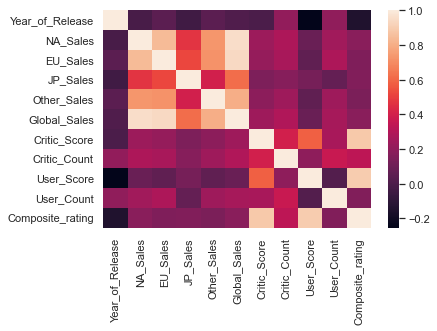

In [8]:
sns.heatmap(gameDF.corr())

Interestingly, the year of release seems to have a negative effect on rating, meaning newer games tend to be less favorably reviewed. Is it possibly because of a nostalgia filter? Or because video games were a completely new form of media, and newer things are more interesting? It could also be due to more commercial games being pumped out in the later years with less care and attention to detail.

There is a clump of very high correlation among sales in North America, the European Union, Japan, and Others. Japan sales are a little less correlated to the other three as the other three are amongst themselves. Maybe the Japanese have specific tastes that NA, EU, and the globe does not fully share.

Anyways, We will only use `Global_Sales` to avoid multicolinearity. It also gives the most complete picture of sales in all markets, and serves as a weighted average of regional tastes.

In [9]:
gameDF = gameDF.drop(["User_Count","Critic_Count", "NA_Sales","EU_Sales", "JP_Sales", "Other_Sales"], axis= 1)

In [10]:
gameDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6825 entries, 0 to 6824
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              6825 non-null   object 
 1   Platform          6825 non-null   object 
 2   Year_of_Release   6825 non-null   int32  
 3   Genre             6825 non-null   object 
 4   Publisher         6825 non-null   object 
 5   Global_Sales      6825 non-null   float64
 6   Critic_Score      6825 non-null   float64
 7   User_Score        6825 non-null   float64
 8   Developer         6825 non-null   object 
 9   Rating            6825 non-null   object 
 10  Composite_rating  6825 non-null   float64
dtypes: float64(4), int32(1), object(6)
memory usage: 560.0+ KB


**Composite_rating**
_______________
First we begin with Composite_rating, which is the target variable of the set. It describes the composite ranking of Users and Critics from the Metacritic dataset.

We expect the average game to get about a 70, with a SD of 10 points, with a symmetric normal distribution.

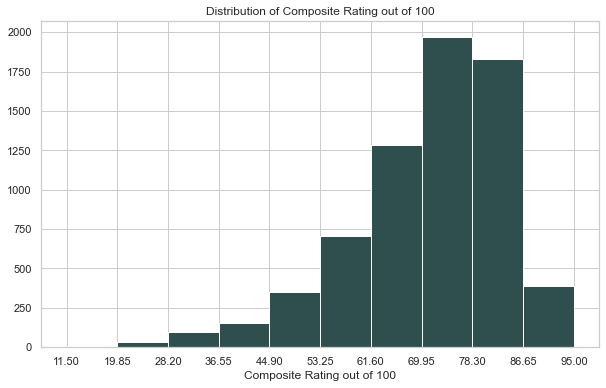

count    6825.000000
mean       71.064176
std        12.564423
min        11.500000
25%        64.500000
50%        73.500000
75%        80.000000
max        95.000000
Name: Composite_rating, dtype: float64

In [11]:
figure = plt.figure(figsize=(10, 6))

data = gameDF.Composite_rating

counts, divisions = np.histogram(data, range=( min(data),max(data)), bins=10)

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(data,  bins=divisions, color="darkslategray")
axes.set_title("Distribution of Composite Rating out of 100")
axes.set_xlabel("Composite Rating out of 100")
axes.set_xticks(bins)

plt.show()
plt.close()
data.describe()


The actual mean was ~71, so our estimate was not far off. However, the distribution is very left skewed. This is probably because it is easier and there is a lot more room to make a sub-par game (0-71) than there is to make an above average game.

**Global_Sales**
_______________

We want to see what the distributions of sales are. How many copies does the average video game sell? Let's estimate 1 million. It may be an gamma distribution with many low-sales games and fewer and fewer high-sales games. 

We chose Global_Sales because it does not play to the preferences of one region, but rather averages all of them. Also with the internet and cheap translation services, we have a more global market now than ever.


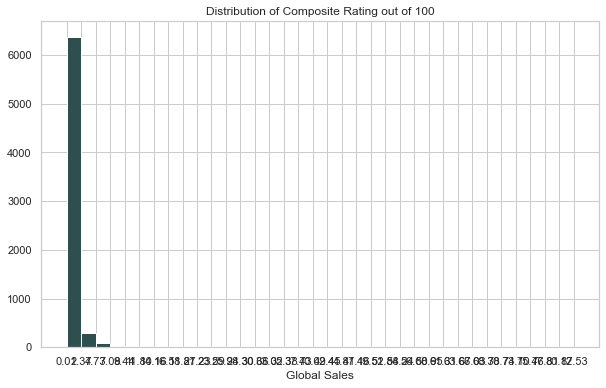

count    6825.000000
mean        0.777590
std         1.963443
min         0.010000
25%         0.110000
50%         0.290000
75%         0.750000
max        82.530000
Name: Global_Sales, dtype: float64

In [12]:
figure = plt.figure(figsize=(10, 6))

data = gameDF.Global_Sales

counts, divisions = np.histogram(data, range=( min(data),max(data)), bins=35)

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(data,  bins=divisions, color="darkslategray")
axes.set_title("Distribution of Composite Rating out of 100")
axes.set_xlabel("Global Sales")
axes.set_xticks(bins)

plt.show()
plt.close()
data.describe()

The result looks like an exponential distribution.

The vast majority of games sell under 1 million (the mean was .777 million) and fewer and fewer games sell higher than that. This chart shows what an outlier Wii Sports is with over 80 million sales.



**Year_of_Release**
_______________

We want to see if the year of release affects a video game's rating. The heatmap shows that there may be a negative correlation.

We first want to see how many titles are released every year.

We expect that the number will grow every year.

<Figure size 720x432 with 0 Axes>

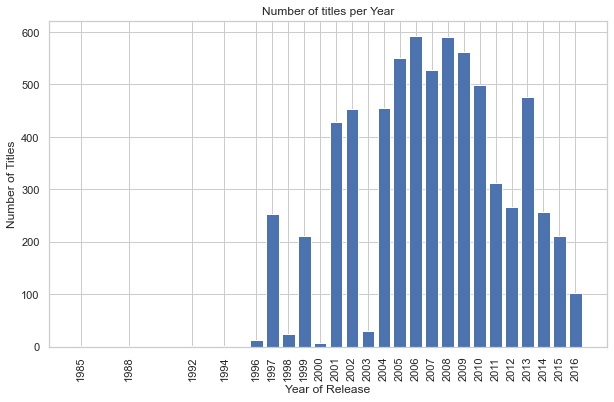

In [13]:
figure = plt.figure(figsize=(10, 6))

data = gameDF.Year_of_Release

figure = plt.figure(figsize=(10, 6))

VC = data.value_counts()
uniquePlatforms = data.unique()

plt.bar(uniquePlatforms , VC)
#print(gameDF.User_Score.unique())
plt.title('Number of titles per Year')
plt.xlabel('Year of Release')
plt.ylabel('Number of Titles')
plt.xticks(np.unique(data) ,  rotation='vertical')

plt.show()


Surprisingly, we seem to have passed "peak game" in terms of the metacritic rankings volume. The maximum number of titles ranked by metacritic came out in 2006-2009, and then waned until 2016. 

The amount of games featured from 1985 -1995 are miniscule, so they will be taken out later because the small set could adversely affect the model.

**Platform**
_______________

We want to see if the platform a game is on affects the rating significantly. That way people who want to make the highest rated game can choose the platform with the best games, as its possible that that platform's technology enhances the games.

There are 17 unique platforms listed.

That may be too many to interpret easily, so we will save that for an additional model.

In [14]:
print("number of Platforms: %d" % gameDF.Platform.nunique())

number of Platforms: 17


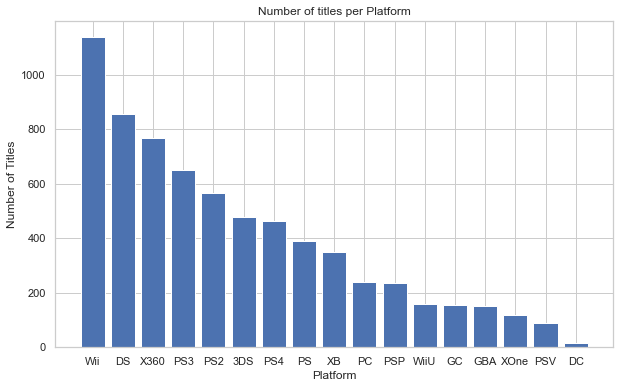

In [15]:
figure = plt.figure(figsize=(10, 6))

data = gameDF.Platform
VC = data.value_counts()
uniquePlatforms = data.unique()

plt.bar(uniquePlatforms , VC)
#print(gameDF.User_Score.unique())
plt.title('Number of titles per Platform')
plt.xlabel('Platform')
plt.ylabel('Number of Titles')

plt.show()


I never knew the Wii and the DS had the most titles of all time! Also this data is from 2016, so the Xbox One and PS5 don't have too many titles yet.

**Rating**
_______________

Does the Rating (target audience) of a game affect the composite ratings (critic + user reviews)?

We predict E rated games are the most popular because they appeal to all people and might have less shocking or unsavory content. 

number of Ratings: 7


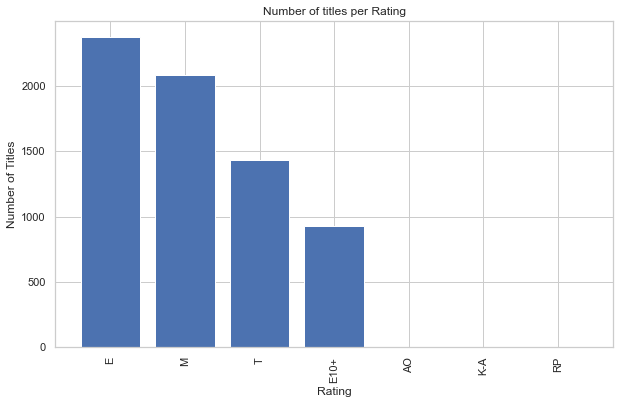

In [16]:
print("number of Ratings: %d" % gameDF.Rating.nunique())

figure = plt.figure(figsize=(10, 6))

data = gameDF.Rating
VC = data.value_counts()
uniquePlatforms = data.unique()

plt.bar(uniquePlatforms , VC)
#print(gameDF.User_Score.unique())
plt.title('Number of titles per Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks( rotation='vertical')

plt.show()

The only major ratings are E, M, T, and E10+. We will ignore the others.

**Genre**
_______________

Does the genre of a game affect the ratings?

Maybe some genres are popular but not highly rated. Think of reality TV! If this is the case, it would be good to know for aspiring game makers to know when to follow the masses and when to buck the trend. 

There are 12 unique Genres listed.

That may be too many to interpret easily, so we will save that for an additional model.





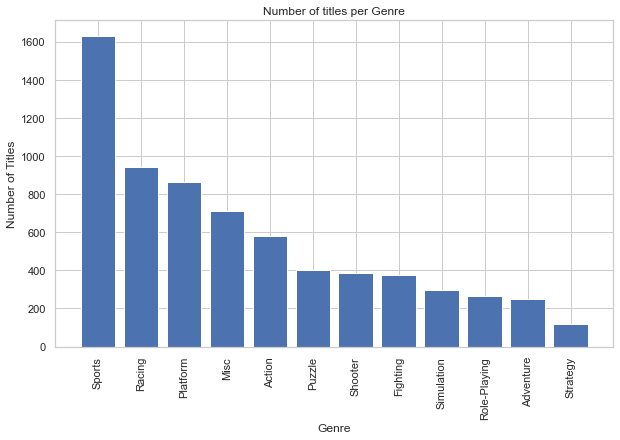

In [17]:
figure = plt.figure(figsize=(10, 6))

data = gameDF.Genre
VC = data.value_counts()
uniquePlatforms = data.unique()

plt.bar(uniquePlatforms , VC)
#print(gameDF.User_Score.unique())
plt.title('Number of titles per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.xticks( rotation='vertical')

plt.show()


I did not think that sports would be the most common genre, but then again, they do often release a "new" game every year, while many other genres do not have that kind of sequel production!

**Bivariate Analysis: Sales Vs. Composite Rating**
_______________


Text(0.5, 1.0, 'Sales Vs. Composite Rating')

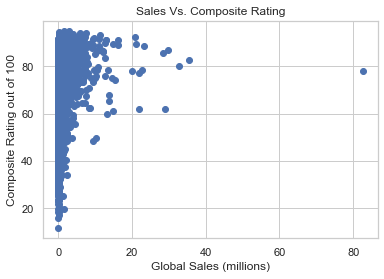

In [18]:
plt.scatter(gameDF.Global_Sales, gameDF.Composite_rating)
plt.xlabel('Global Sales (millions)')
plt.ylabel('Composite Rating out of 100')
plt.title("Sales Vs. Composite Rating")

Wii Sports is a high-leverage point- an outlier! As much as we love wii sports, it is an outlier also because people didn't "buy" it in particular, it came with the wii.
We should remove it, to investigate if ratings are truly correlated with sales without Wii Sports affecting the distribution by a huge amount.

**Removing outlier: Wii Sports**

In [19]:
gameDF = gameDF.drop(labels=None, axis=0, index= 0 , columns=None, level=None, inplace=False, errors='raise')
#gameDF

Text(0.5, 1.0, 'Sales Vs. Composite Rating')

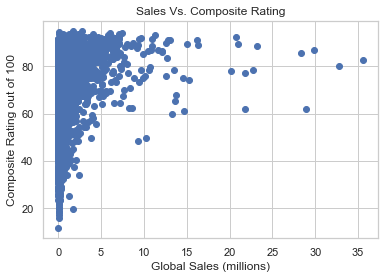

In [20]:
plt.scatter(gameDF.Global_Sales, gameDF.Composite_rating)
plt.xlabel('Global Sales (millions)')
plt.ylabel('Composite Rating out of 100')
plt.title("Sales Vs. Composite Rating")

Removing Wii sports made the distribution more homogenous. It also shows that low selling games can get high scores. However, in general there does seem to be a positive correlation with sales and composite rating scores.

**Year of Release**
__________

Text(0.5, 1.0, 'Year of Release Vs. Composite Rating')

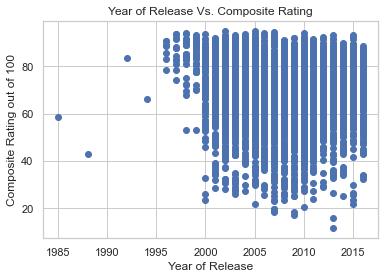

In [21]:
plt.scatter(gameDF.Year_of_Release, gameDF.Composite_rating)
plt.xlabel('Year of Release')
plt.ylabel('Composite Rating out of 100')
plt.title("Year of Release Vs. Composite Rating")

There are only four points before 1995. This may have been the "systemic bias" hypothesized about in the metacrtic rating data. The original data actually has 488 video game titles before 1995, but only 4 of those recieved scores on metacritic. 

In fact, the pre-2000 data is pretty sparse too. It might be wise to re-frame the question to be limited to video games titles released 2000 and after. 

**Changing domain to 2000 and onwards:**

Text(0.5, 1.0, 'Year of Release Vs. Composite Rating year 2000 - 2016')

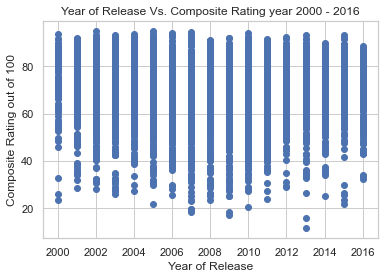

In [22]:
gameDF = gameDF[ gameDF.Year_of_Release >1999]
#gameDF

plt.scatter(gameDF.Year_of_Release, gameDF.Composite_rating)
plt.xlabel('Year of Release')
plt.ylabel('Composite Rating out of 100')
plt.title("Year of Release Vs. Composite Rating year 2000 - 2016")

This data looks much more consistent, but since all the data blurs together, and since the data is discrete it is quantized on the x- axis, it would show the statistics better in a box-and-whisker plot.

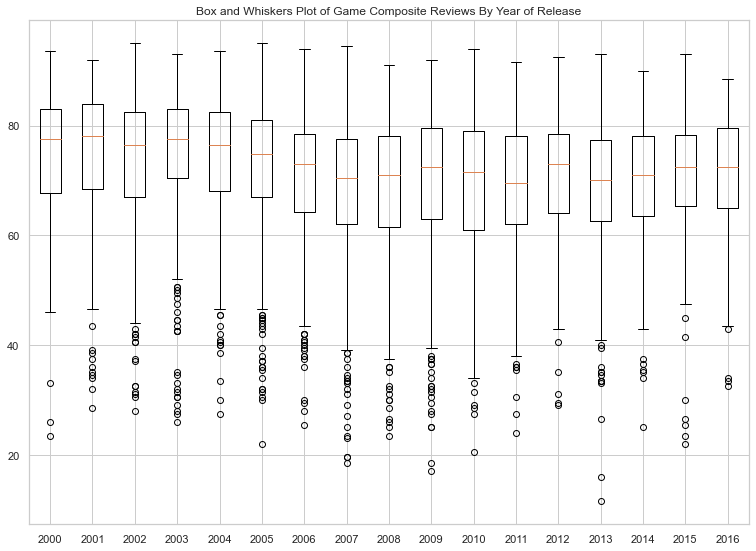

In [23]:
#References: https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
#https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html#
years = np.unique(gameDF.Year_of_Release)
gameDF[gameDF["Year_of_Release"] == years[0] ]

data = []

#loop thru all years and create a list of the composite ratings that year
#this will allow box plots for each year to be made
for year in years:
    year_data = gameDF[gameDF["Year_of_Release"] == year ] 
    data.append(year_data["Composite_rating"])

fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
#plt.xticks(labels = years)
ax.set_xticklabels(years)
# Creating plot
bp = ax.boxplot(data)
# show plot

plt.title("Box and Whiskers Plot of Game Composite Reviews By Year of Release")
plt.show()

There is a negative trend in the average video game rating, which could not be seen in the previous plot. In 2000 the average video game rating was in the high 80s, but around 2006 it dropped to the mid 80s. This corresponds with the time that video game ratings were at their max, from the Year_of_release chart. Possibly there is an inverse relationship between quality and quantity?

# Linear_Model
[Back to Top](#Contents)




In [25]:
import models


model = "Composite_rating ~ Global_Sales +Year_of_Release "
result1 = models.bootstrap_linear_regression(model, data= gameDF)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,915.86,774.43,1081.90
Global_Sales,$\beta_{1}$,1.51,1.27,1.92
Year_of_Release,$\beta_{2}$,-0.42,-0.50,-0.35
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,12.16,11.84,12.40,
$R^2$,0.06,0.05,0.07,


Now let us check the residuals for data:

In [26]:
#Borrowed from Dr. Butcher: "lab 10 - solution"
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    #variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(scaledDF[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

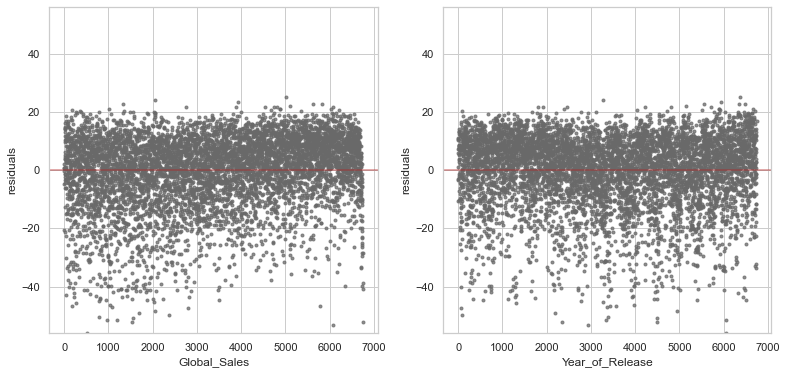

In [27]:
residuals1 = plot_residuals(result1, ["Global_Sales", "Year_of_Release"])

The $R^2$ of the model is very low at about 0.07. The sigma is very high too, at 12.15. This model is not useful for prediction, but it does a little explaination of the dataset. The residuals show that a linear model is a good fit, as the residuals are uncorrelated and have a constant variance.


The `Global_Sales` were correlated with the rating, and the data strongly supports this, as the entire 95% BCI was positive. 

This was expected, to see that global sales correlated with score, although that may be putting the cart before the horse in terms of causality. Better games have higher ratings and more sales (in a perfect world).

`Year_of_Release` actually negatively correlated with score. It is pretty certain this is the case, because the 95% BCI is entirely negative. However, the degree of the effect is less than that of `Global_sales`.




Now let's add factors like rating and genre.

### Linear Model with Genre:

In [28]:
#One hot encode the 12 genres:
gameDF_genre = pd.concat([gameDF, pd.get_dummies(gameDF["Genre"])], axis=1)

gameDF_genre

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,User_Score,Developer,Rating,...,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.52,82.0,8.3,Nintendo,E,...,0,0,0,0,1,0,0,0,0,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,32.77,80.0,8.0,Nintendo,E,...,0,0,0,0,0,0,0,0,1,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,29.80,89.0,8.5,Nintendo,E,...,0,0,1,0,0,0,0,0,0,0
4,Wii Play,Wii,2006,Misc,Nintendo,28.92,58.0,6.6,Nintendo,E,...,0,1,0,0,0,0,0,0,0,0
5,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.32,87.0,8.4,Nintendo,E,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,46.0,2.4,Fluid Studios,E,...,0,0,0,0,0,0,0,0,0,0
6821,Mortal Kombat: Deadly Alliance,GBA,2002,Fighting,Midway Games,0.01,81.0,8.8,Criterion Games,M,...,1,0,0,0,0,0,0,0,0,0
6822,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,7.6,Kojima Productions,M,...,0,0,0,0,0,0,0,0,0,0
6823,Breach,PC,2011,Shooter,Destineer,0.01,61.0,5.8,Atomic Games,T,...,0,0,0,0,0,0,1,0,0,0


In [29]:
import models
#Fighting	Misc	Platform	Puzzle	Racing	Role-Playing	Shooter	Simulation	Sports	Strategy
#+ Platform + Puzzle +Racing +Shooter+Simulation+Sports+Strategy 
#Don't include Platform: empty
model = "Composite_rating ~ Global_Sales +Year_of_Release +Fighting +Misc  + Puzzle +Racing +Shooter + Simulation + Sports + Strategy"
result2= models.bootstrap_linear_regression(model, data= gameDF_genre)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,899.38,765.25,1043.63
Global_Sales,$\beta_{1}$,1.55,1.25,1.93
Year_of_Release,$\beta_{2}$,-0.41,-0.48,-0.35
Fighting,$\beta_{3}$,0.28,-1.48,1.55
Misc,$\beta_{4}$,-3.42,-4.72,-1.96
Puzzle,$\beta_{5}$,0.42,-1.86,2.38
Racing,$\beta_{6}$,-1.37,-2.46,-0.22
Shooter,$\beta_{7}$,-0.38,-1.51,0.40
Simulation,$\beta_{8}$,-0.26,-1.99,1.14


When all genres are included: 

The R2 did not rise, and the sigma did not fall. However there were some trends within the genres.

Overall trends of how the Genre correlates with the average rating, factoring the 95%BCI of the coefficient (Sales and Year of release accounted for as well):


Genre | Effect on Rating |
------|-----------|
Fighting | Indeterminate|
Misc. | Below Average |
Puzzle | Indeterminate|
Racing | Below Average|
Shooter | Indeterminate|
Simulation | Indeterminate|
Sports |  Above Average|
Strategy | Above Average (*)|

*Strategy actually had the biggest positive effect on ratings of any genre, but the sample size was small (about 100 games). 

Strategy had the highest composite rating score  on average, and Misc. had the least score on average.

### Linear Model with Rating:

The four ratings with significant numbers of titles are: 
- E (Everybody)
- E10+ (Everybody over age 10)
- T (Teen, over age 13)
- M (Mature, over age 17)

For more information on ratings, [check out this link](https://www.esrb.org/ratings-guide/).

We predict E rated games are the highest rated because they appeal to all people and might have less shocking or unsavory content. 




In [30]:
#One hot encode the 12 genres:
gameDF_rating = pd.concat([gameDF, pd.get_dummies(gameDF["Rating"])], axis=1)

#due to incompatibility with the patsy system, we rename E10+ to E10plus
gameDF_rating = gameDF_rating.rename(columns={"E10+":"E10plus"})

gameDF_rating

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,User_Score,Developer,Rating,Composite_rating,AO,E,E10plus,M,RP,T
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.52,82.0,8.3,Nintendo,E,82.5,0,1,0,0,0,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,32.77,80.0,8.0,Nintendo,E,80.0,0,1,0,0,0,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,29.80,89.0,8.5,Nintendo,E,87.0,0,1,0,0,0,0
4,Wii Play,Wii,2006,Misc,Nintendo,28.92,58.0,6.6,Nintendo,E,62.0,0,1,0,0,0,0
5,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.32,87.0,8.4,Nintendo,E,85.5,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,46.0,2.4,Fluid Studios,E,35.0,0,1,0,0,0,0
6821,Mortal Kombat: Deadly Alliance,GBA,2002,Fighting,Midway Games,0.01,81.0,8.8,Criterion Games,M,84.5,0,0,0,1,0,0
6822,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,7.6,Kojima Productions,M,78.0,0,0,0,1,0,0
6823,Breach,PC,2011,Shooter,Destineer,0.01,61.0,5.8,Atomic Games,T,59.5,0,0,0,0,0,1


In [31]:
import models

#+ E10plus +T + M
model = "Composite_rating ~ Global_Sales +Year_of_Release + E+T +M "
result3 = models.bootstrap_linear_regression(model, data= gameDF_rating)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,928.07,815.37,1054.30
Global_Sales,$\beta_{1}$,1.50,1.24,1.91
Year_of_Release,$\beta_{2}$,-0.43,-0.49,-0.37
E,$\beta_{3}$,0.69,-0.37,1.57
T,$\beta_{4}$,1.71,0.72,2.59
M,$\beta_{5}$,2.29,1.26,3.22
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,12.14,11.86,12.37,


When E10+ was included, the ranges did not make sense. So it was taken out.

Overall trends of how the age Rating correlates with the average review rating, factoring the 95%BCI of the coefficient (Sales and Year of release accounted for as well):


Age Rating | Effect on Review Rating |
------|-----------|
E | Indeterminate|
T | Above Average |
M | Above Average |

This was a surprising effect. It was hypothesized that E games would be higher rated. One possible explaination is that Mature games explore more "Mature" themes that correlate with high ratings. Also children's movies usually don't win best picture in the Oscars.

Also, apparently the average age of a gamer is 35 [1]. This could also factor into why M games seem to be the highest rated controlling for sales and year of release.



[1] https://www.gamesparks.com/blog/the-average-gamer-how-the-demographics-have-shifted/

### Linear Model with Platform:

What platform should we make games for if we want highly rated games? If a certain platform has games with higher critical ratings on average, it might be worth targeting that platform. 

The platforms in the database are: 
- '3DS'
- 'DC'
- 'DS'
- 'GBA'
- 'GC'
- 'PC'
- 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV'
- 'Wii', 'WiiU'
- 'X360', 'XB', 'XOne'



In [33]:
#One hot encode the 17 platforms:
gameDF_platform = pd.concat([gameDF, pd.get_dummies(gameDF["Platform"])], axis=1)
#due to incompatibility with the patsy system, we rename 3ds to DS3

gameDF_platform = gameDF_platform.rename(columns={"3DS":"DS3"})
gameDF_platform

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,User_Score,Developer,Rating,...,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.52,82.0,8.3,Nintendo,E,...,0,0,0,0,0,1,0,0,0,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,32.77,80.0,8.0,Nintendo,E,...,0,0,0,0,0,1,0,0,0,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,29.80,89.0,8.5,Nintendo,E,...,0,0,0,0,0,0,0,0,0,0
4,Wii Play,Wii,2006,Misc,Nintendo,28.92,58.0,6.6,Nintendo,E,...,0,0,0,0,0,1,0,0,0,0
5,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.32,87.0,8.4,Nintendo,E,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,46.0,2.4,Fluid Studios,E,...,0,0,0,0,0,0,0,0,0,0
6821,Mortal Kombat: Deadly Alliance,GBA,2002,Fighting,Midway Games,0.01,81.0,8.8,Criterion Games,M,...,0,0,0,0,0,0,0,0,0,0
6822,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,7.6,Kojima Productions,M,...,0,0,0,0,0,0,0,0,0,0
6823,Breach,PC,2011,Shooter,Destineer,0.01,61.0,5.8,Atomic Games,T,...,0,0,0,0,0,0,0,0,0,0


In [46]:
import models

#Platforms
#model = "Composite_rating ~ Global_Sales +Year_of_Release + DS3+DC+DS+GBA+GC+PC+PS+PS2+PS3+PS4+PSP+PSV+Wii+WiiU+X360+XB+XOne"
model = "Composite_rating ~ Global_Sales +Year_of_Release +Wii + DS + X360 + PS3 +PS2 + DS3 + PS4 + PS + XB+ PC "
result4 = models.bootstrap_linear_regression(model, data= gameDF_platform)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,796.97,640.01,976.11
Global_Sales,$\beta_{1}$,1.70,1.42,2.04
Year_of_Release,$\beta_{2}$,-0.36,-0.45,-0.28
Wii,$\beta_{3}$,-6.32,-7.42,-4.92
DS,$\beta_{4}$,-4.11,-5.29,-2.85
X360,$\beta_{5}$,-3.73,-4.59,-2.70
PS3,$\beta_{6}$,-2.57,-3.53,-1.55
PS2,$\beta_{7}$,-0.86,-1.79,-0.22
DS3,$\beta_{8}$,-1.92,-3.88,-0.21


When the top 10  platforms are included: 

The R2 did  rise to 0.09 average from 0.06 average. 

Overall trends of how the Genre correlates with the average rating, factoring the 95%BCI of the coefficient (Sales and Year of release accounted for as well):


Platform | Effect on Rating |
------|-----------|
Wii | Below Average|
DS | Below Average |
X360 | Below Average|
PS3 | Below Average|
PS2 | Below Average|
3DS | Below Average|
PS4 | Below Average|
PS |Below Average|
XB | Indeterminate|
PC | Above Average|

Out of the top 10 platforms, only PC had above average ratings for their games. Maybe its because PC is more powerful or has a higher limit of capabilities. It also may be because the games reviewed on PC are the higher caliber games which recieve highre rankings.

All the other platforms had below average or indeterminate rankings, but the original XB and original Playstation had the highest average coefficients. Maybe there is a nostalgia factor, or maybe there is a sense of "the original is always the best, and sequels can never compare".

Wii had the lowest average rankings though, so maybe it would be best to avoid that console. It is underpowered compared to its peers and some people might have found its controls too whimsical.


# Model_validation
[Back to Top](#Contents)

We will do a 10 fold validation on our model and then do a bootstrap on those results to get a 95% confidence interval on what our output will be.

Then we will take a bootstrap of the *difference* between the base model (year of release + sales) and the model including Platform

First we take the 10-fold validation of the base model:

In [48]:
'''
#@input: data dataframe
#@input: outputLabel string, name of column in dataframe which is the class label or regression output
input: number of folds, nfolds (int)
input: model - a patsy notation model to plug into linear bootstrap(string)


output: dictionary of 10 r2 values in ["r_squared"]
and 10 sigma values in ["sigma"]

'''
def nFoldValidation(data, outputLabel,  model, numFolds = 10):
    ################
    #VALIDATION SET#
    ################
    
    #shuffle data
    data_shuffled = data.sample(frac=1)
    
    #break data into 10% pieces
    dataSize = len(data)
    chunkSize = dataSize//numFolds
    
    chunkedData = {}

    for index in range(numFolds):
        beginning = index*chunkSize
        end = (index+1)*chunkSize 
        chunkedData[index] = data_shuffled.iloc[beginning:end ,:]

    #return chunkedData  
    
    ##########
    #Stratify#
    ##########

    
    ################
    #TEST EACH FOLD#
    ################
    foldNumbers = range(numFolds)#[0,1,2,3,4,5,6,7,8,9]
    foldNumbersR_squared = list()
    foldNumbersSigma = list()
    
    
    test =  pd.DataFrame()
    train =  pd.DataFrame()
    #iterate through number of Folds
    #create test list and train list
    for testNum in foldNumbers:
        print("trial ", testNum)
        for otherNum in foldNumbers:
            if otherNum == testNum:
                test = pd.concat([test, chunkedData[otherNum]])
            else:
                train = pd.concat([train, chunkedData[otherNum]])
                
        #train data on train set
        #resultTrain = finalLinearModel(train)
        
        resultTrain = models.bootstrap_linear_regression(model, data= train)

        foldNumbersSigma.append(resultTrain['sigma'])
        foldNumbersR_squared.append(resultTrain['r_squared'])
        
        #Reset test and train after modelling
        test =  pd.DataFrame()
        train =  pd.DataFrame()
        
        print()
    ######
    #PLOT#
    ######

    
    #Return Data, in a dictionary including R2,sigma values for each fold's model
    returnDict = {}
    returnDict["r_squared"] = foldNumbersR_squared
    returnDict["sigma"] = foldNumbersSigma
    
    return returnDict
  


'''
################################
#Method Call fiveFoldValidation#
################################
'''
#BASE MODEL

model = "Composite_rating ~ Global_Sales +Year_of_Release "
base_model_10_fold = nFoldValidation(gameDF,'Composite_rating', model = model)


print("R2 values for each fold's model:")
print(base_model_10_fold["r_squared"])

print("Min R2:")
print(min(base_model_10_fold["r_squared"]))
      
print("Max R2:")
print(max(base_model_10_fold["r_squared"]))

print("Sigma values for each fold's model:")
print(base_model_10_fold["sigma"])

#PLatform MODEL
model_platform = "Composite_rating ~ Global_Sales +Year_of_Release +Wii + DS + X360 + PS3 +PS2 + DS3 + PS4 + PS + XB+ PC "
platform_model_10_fold = nFoldValidation(gameDF_platform,'Composite_rating', model = model_platform)

print("~~~~~ PLATFORM DEPENDENT MODEL ~~~~~~")
print("\nR2 values for each fold's model :")
print(platform_model_10_fold["r_squared"])

print("Min R2:")
print(min(platform_model_10_fold["r_squared"]))
      
print("Max R2:")
print(max(platform_model_10_fold["r_squared"]))

print("Sigma values for each fold's model:")
print(platform_model_10_fold["sigma"])

trial  0

trial  1

trial  2

trial  3

trial  4

trial  5

trial  6

trial  7

trial  8

trial  9

R2 values for each fold's model:
[0.05513174879401117, 0.05825279235732861, 0.05895518172254621, 0.06028123297823618, 0.05834372492623263, 0.057211905232212645, 0.058636980261847826, 0.057711504821278736, 0.059415974739628896, 0.05863177361766747]
Min R2:
0.05513174879401117
Max R2:
0.06028123297823618
Sigma values for each fold's model:
[12.17387228671273, 12.167016630924058, 12.207883652053232, 12.130913801903652, 12.13420264015435, 12.12438127032864, 12.14165272341166, 12.125640524668169, 12.170773551643636, 12.133537918487812]
trial  0

trial  1

trial  2

trial  3

trial  4

trial  5

trial  6

trial  7

trial  8

trial  9

~~~~~ PLATFORM DEPENDENT MODEL ~~~~~~

R2 values for each fold's model :
[0.0887788039954357, 0.08596813118494517, 0.08897080348102504, 0.09020764633593747, 0.0944971436554577, 0.08987166937894397, 0.09556478740752572, 0.09054849785670527, 0.08586550125092662, 0.

Now we have the 10 fold validation R2 values for the base model and for the platform model, we can take the bootstraps of each list and then take the difference of the bootstraps.

In [49]:
#Borrowed from Dr. Butcher - lab 12 solutions
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [50]:
#Boostrap our R2 values for base model and platform model
base_model_bootstrap = bootstrap_sample(base_model_10_fold["r_squared"], np.mean)
platform_model_bootstrap = bootstrap_sample(platform_model_10_fold["r_squared"], np.mean)
difference = platform_model_bootstrap - base_model_bootstrap

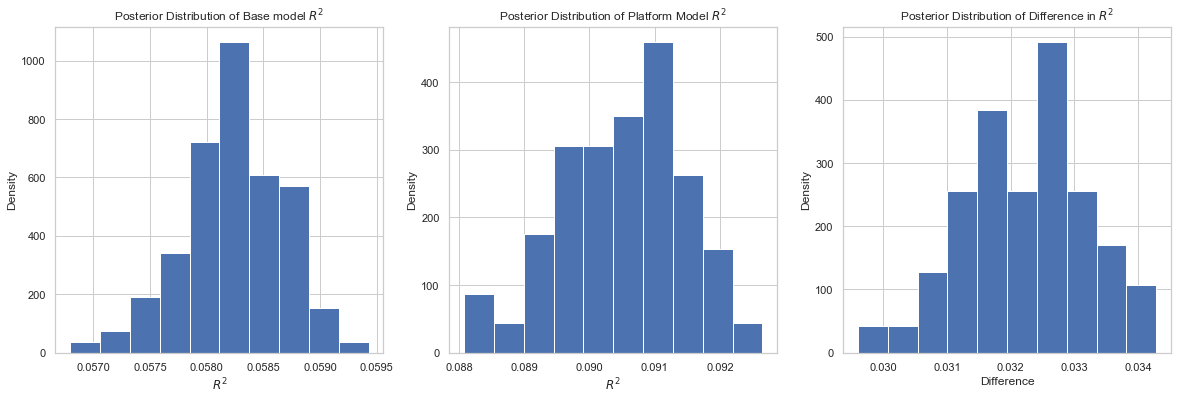

In [51]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(base_model_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Base model $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(platform_model_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Platform Model $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [52]:
print("P(platform model R2 > base model R2)", np.mean(difference > 0))

P(platform model R2 > base model R2) 1.0


Now we do a differences of means test by finding out the probability that the platform model produced a higher R2 than the base model.

The probability that the $R^2$ value of the platform model is greater than that of the base model is 100%!

# Conclusion
[Back to Top](#Contents)

\
This overview provides an explanatory analysis of what factors correlate with a high composite rating for a video game (metacritic average of user and critic score).

**Year of Release**

There was a slight negative trend between year of release and score. Its possible that

This is not something a video game producer can account for (unless you have a time machine, which would also make a cool video game), but it will help analyze the state of the industry and help people consider how video games have changed over time. 

**Sales**

There was a positive trend between global sales and composite rankings.

This may have been an example of a lurking variable, where games that are inherently "good" tend to sell more and also get higher ratings. It could also mean that humans are social creatures, and things that are popular are liked more, because the people reviewing the games have friends who play the game, which increases their enjoyment.

To the video game designer producer, this says don't be afraid of selling a lot of games, since it is correlated with higher scores. This probably isn't an issue but maybe some people would fetishize the "indie game" feel and think that getting more sales means lower scores, when in general, it does not.

**Genre**

There were significant effects of Genre on the composite score recieved. 

The lowest scoring genre was `Misc.`. Possibly it helps to have a focus, and to stick to the major themes that people like.

The highest scoring genre was `Strategy`, although it was the smallest category as well with only about 100 titles. `Sports` was the other above-average rated category.

Its not to say that a `Misc.` genre game cannot be highly rated. However, it seems that making a `Strategy` game is more likely to become highly rated.

**Age Rating**

M-rated games has the highest average review ratings of the ratings "E", "T", and "M". 

Exploring mature themes and adding some bad words into the game might lead to a game more similar to those with better ratings. 

**Platform**

The probability that the $R^2$ value of the platform model is greater than that of the base model is 100%!

PC had the best effect on average rankings. Wii had the worst. This may be because video games, more so than other types of entertainment, are constraiend by hardware technology. PC is known for being the most powerful gaming machines, and maybe those factors attract serious gamers and highly rated games.

____


Ravi Shankar

12/10/21
